In [1]:
import random
import string
import math
import time
import itertools
from math import log as ln
from math import exp
import pandas as pd
import numpy as np
from gurobipy import *
from scipy import spatial
from scipy import sparse
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import squareform, pdist

plt.rcParams['text.usetex'] = True

In [45]:
def mock(num=10, size=10, seed=None):
    "return dataframe of simulated objects"
    if seed is not None: 
        np.random.seed(seed)
    obj = np.random.random(size=(num,3)) 
    obj[:,0:2] *= size;  obj[:,1] -= size/2 #The location is scaled to simulate objects on a 10x10 grid. 
    #objid = np.arange(obj.shape[0]) # object id
    df = pd.DataFrame(obj,columns=['x','y','u'])
    return df

def cat(mdf):
    "return simulated catalog and selection"
    sigma = 1/100*np.random.randint(4, 10, (mdf.shape[0],1))
    det = mdf.values[:,:2] + sigma * np.random.randn(mdf.shape[0],2)
    df = pd.DataFrame(det,columns=['x','y'])
    df['Sigma'] = sigma
    a, b = (0,1)
    sel = np.logical_and(mdf.u>=a, mdf.u<b)
    return df.values, sel

def random_cat(mdf):
    "return simulated catalog with random selection intervals"
    sigma = 1/100*np.random.randint(4, 10, (mdf.shape[0],1))
    det = mdf.values[:,:2] + sigma * np.random.randn(mdf.shape[0],2)
    df = pd.DataFrame(det,columns=['x','y'])
    df['Sigma'] = sigma
    num_endpoints = random.randrange(6,10,2) #Random multiple of 2 from 6 to 16 #So the number of intervals = num_endpoints / 2
    endpoints_list = sorted([random.random() for x in range(num_endpoints)])
    selection_boolean_list = []
    for index in range(int(num_endpoints/2)):
        a = endpoints_list[2*index]
        b = endpoints_list[2*index+1]
        sel = np.logical_and(mdf.u>=a, mdf.u<b)
        selection_boolean_list.append(sel)
    final_sel = selection_boolean_list[0]
    for i in range(1,int(num_endpoints/2)):
        final_sel = final_sel | selection_boolean_list[i]
    df = df[final_sel].values
    return df, final_sel

def get_candidate_list(clustering_result, catalog_label, clustering_label):
    candidate_dict = {}
    list_of_label = catalog_label[np.where(clustering_result.labels_==clustering_label)] #The catalog id of all sources found in the island
    for j in np.unique(list_of_label):
        list_of_indices = []
        for k in range(sum(list_of_label==j)):
            list_of_indices.append(((np.where(cmat[j][:,:2]==clustering_result.components_[np.where(clustering_result.labels_==clustering_label)][list_of_label==j][k])[0][0]), j))
        candidate_dict[j] = list_of_indices # catalog id: (source id, catalog id)

    # Get all the (catalog_id, source_id) pairs
    candidate_list = []
    for key in candidate_dict.keys():
        list_of_value = candidate_dict[key]
        for pair in list_of_value:
            candidate_list.append(pair)

    catalog_list = []
    source_list = []
    coord_1_list = []
    coord_2_list = []
    Sigma_list = []
    for catalog_source_pair in candidate_list:
        catalog_list.append(catalog_source_pair[1])
        source_list.append(catalog_source_pair[0])
        coord_1_list.append(cmat[catalog_source_pair[1]][catalog_source_pair[0]][0])
        coord_2_list.append(cmat[catalog_source_pair[1]][catalog_source_pair[0]][1])
        Sigma_list.append(cmat[catalog_source_pair[1]][catalog_source_pair[0]][2])
    df = pd.DataFrame({'Catalog_id': catalog_list, 'Source_id': source_list, 'Coordinate_1': coord_1_list, 'Coordinate_2': coord_2_list}) #Make a dataframe from the information provided
    return(candidate_list, df, catalog_list, Sigma_list)

def get_distance(list_of_indexes, df):
    '''
    Given 2 pairs of (source_index, catalog_index), return the square distance between them
    df has the columns ('Catalog id', 'Source id', Coord 1, Coord 2)
    '''
    coord_list = []
    for i in range(2):
        coord_list+=[np.array(df[(df['Catalog_id'] == list_of_indexes[i][1]) & (df['Source_id'] == list_of_indexes[i][0])].iloc[:,-2:])[0]]
    array_matrix = np.array(coord_list)
    return(np.linalg.norm(array_matrix[1]-array_matrix[0])**2)

def get_distance_2(list_of_indexes, coord_dict):
    '''
    Given 2 pairs of (source_index, catalog_index), return the square distance between them
    df has the columns ('Catalog id', 'Source id', Coord 1, Coord 2)
    '''
    c1 = coord_dict[list_of_indexes[0]]
    c2 = coord_dict[list_of_indexes[1]]
    
    return ((c1[0] - c2[0]) ** 2) + ((c1[1] - c2[1]) ** 2)

def sum_of_distance(list_of_objects, df):
    '''
    Given n pairs of (catalog_index, source_index), return the sum of all pairwise square distance.
    '''
    num_of_objects = len(list_of_objects)
    coord_list = []
    for i in range(num_of_objects):
        coord_list+=[np.array(df[(df['Catalog_id'] == list_of_objects[i][1]) & (df['Source_id'] == list_of_objects[i][0])].iloc[:,-2:])[0]]
    array_matrix = np.array(coord_list)
    pairwise_dist = spatial.distance.pdist(np.array(array_matrix))**2
    sum_of_square_dist = sum(pairwise_dist)
    return sum_of_square_dist

def Bayes_factor(list_of_objects, coord_dict):
    '''
    Compute -ln B_o
    given a list of tuples assigned to the same object.
    '''
    sum_ln_kappa_rad = 0
    kappa_rad_sum = 0
    kappa_sum = 0
    neg_ln_Bayes = 0
    num_of_objects = len(list_of_objects)
    
    for tup in list_of_objects:
        sum_ln_kappa_rad += ln(kappa_rad_dict[tup])
        kappa_rad_sum += kappa_rad_dict[tup]
        kappa_sum += kappa_dict[tup]
    
    double_sum = 0
    
    for index_1 in range(num_of_objects):
        for index_2 in range(index_1+1,num_of_objects):
            double_sum += (kappa_dict[list_of_objects[index_1]] *
                           kappa_dict[list_of_objects[index_2]] *
                           get_distance_2([list_of_objects[index_1], 
                                           list_of_objects[index_2]], 
                                           coord_dict))
    
    double_sum *= (1/(2*kappa_sum))
    
    neg_ln_Bayes = double_sum + ((1 - num_of_objects)*ln(2)) - sum_ln_kappa_rad + ln(kappa_rad_sum)
    return neg_ln_Bayes

def compute_distance_dictionary(list_of_indices, df):
    '''
    Return a dictionary with the form: dict[('Source_id_1', 'Catalog_id_1'), ('Source_id_2', 'Catalog_id_2')] = square distance between them. 
    '''
    distance_dict = {}
    for current_pair_index in range(len(list_of_indices)):
        for next_pair_index in range(current_pair_index + 1, len(list_of_indices)):
            if list_of_indices[next_pair_index][1]!= list_of_indices[current_pair_index][1]: # Only find distances for sources from different catalogs
                distance_dict[(list_of_indices[current_pair_index],list_of_indices[next_pair_index])] = get_distance([list_of_indices[current_pair_index],list_of_indices[next_pair_index]], df)
    return distance_dict

def compute_distance_dictionary_2(list_of_indices, coord_dict):
    '''
    Return a dictionary with the form: dict[('Source_id_1', 'Catalog_id_1'), ('Source_id_2', 'Catalog_id_2')] = square distance between them. 
    '''
    distance_dict = {}
    for current_pair_index in range(len(list_of_indices)):
        for next_pair_index in range(current_pair_index + 1, len(list_of_indices)):
            if list_of_indices[next_pair_index][1]!= list_of_indices[current_pair_index][1]: # Only find distances for sources from different catalogs
                distance_dict[(list_of_indices[current_pair_index],list_of_indices[next_pair_index])] = get_distance_2([list_of_indices[current_pair_index],list_of_indices[next_pair_index]], coord_dict)
    return distance_dict


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    
    ind = linear_sum_assignment(w.max() - w)
    ind = np.array(list(zip(*ind)))
    
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def plot_obj_dict(obj_dict, method, neg_log_bayes, acc, filename = None):
    plt.figure(figsize=(4,4))
    plt.title(f"Clustered via {method} \n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes:.2f}$ \n"
              fr"Accuracy = ${acc * 100:.2f}$ \%")
    for tup_list in obj_dict.values():
        X = [coord_dict[t] for t in tup_list]
        X = np.array(X)
        plt.scatter(X.T[0], X.T[1],s=5.0)
    
    if filename:
        plt.savefig(filename, bbox_inches="tight", pad_inches=0.2, format="svg")
    
    plt.show()

def plot_catalogs(cat_tups, filename = None):
    catalog_groups = defaultdict(list)
    for t in cat_tups:
        catalog_groups[t[1]].append(t)
    plt.figure(figsize=(4,4))
    plt.title("Sources by Catalog")
    for l in catalog_groups.values():
        X = [coord_dict[t] for t in l]
        X = np.array(X)
        plt.scatter(X.T[0], X.T[1],s=5.0)
    
    if filename:
        plt.savefig(filename, format="svg")
    
    plt.show()
    

def plot_objects(cat_tups, filename = None):
    catalog_groups = defaultdict(list)
    for t in cat_tups:
        catalog_groups[t[0]].append(t)
    plt.figure(figsize=(4,4))
    plt.title("Sources by Object\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes_from_obj_dict(catalog_groups, coord_dict):.2f}$")
    for l in catalog_groups.values():
        X = [coord_dict[t] for t in l]
        X = np.array(X)
        plt.scatter(X.T[0], X.T[1],s=5.0)
    
    if filename:
        plt.savefig(filename, format="svg")
    
    plt.show()
    
def neg_log_bayes_from_obj_dict(obj_dict, coord_dict):
    """
    Calculate the total negative log bayes factor
    from a dictionary of object lists.
    """
    neg_log_bayes = 0
    for tup_list in obj_dict.values():
        neg_log_bayes += Bayes_factor(tup_list, coord_dict)
    return neg_log_bayes

def obj_dict_to_true_pred_labels(obj_dict):
    pred_dict = dict()
    true_dict = dict()
    
    for k,l in obj_dict.items():
        for t in l:
            pred_dict[t] = k
            true_dict[t] = t[0]
    
    n_samples = len(pred_dict)
    y_pred = np.zeros(n_samples, dtype=int)
    y_true = np.zeros(n_samples, dtype=int)
    
    for i, (t,label) in enumerate(pred_dict.items()):
        y_pred[i] = label
        y_true[i] = true_dict[t]
    
    return y_pred, y_true

# Create a simulated universe with different selection intervals for catalogs

In [24]:
num_catalog = 200
np.random.seed(42)

In [41]:
num=100
size=30
Qmat=np.empty((1,2))
m = mock(num=num,size=size, seed = 20)
# generate 3 catalogs with sigma=0.1" and different selection intevals
cmat = []
sel_list = []
for i in range(num_catalog): #List of catalogs with coordinates and conditions
    catalog_i, final_sel = cat(m)
    cmat.append(catalog_i)
    sel_list.append(final_sel)

true_matching_dict = {}
count_list = [0]*num_catalog
for source_index in range(num):
    index_list = []
    for catalog_index in range(num_catalog):
        if sel_list[catalog_index][source_index] == True:
            index_list.append((catalog_index, count_list[catalog_index]))
            count_list[catalog_index]+=1
    true_matching_dict[source_index] = index_list

# fig = plt.figure(figsize=(5,5))
# for i in range(num_catalog):
#     x, y = cmat[i][:,:2].T
#     plt.scatter(x,y,s=1.0)
# plt.show()

In [13]:
m_new_npy = np.array(
    [
        [0.0, 0.0, 0.7],
        [0.0, 0.9, 0.75]
    ]
)
m_new = pd.DataFrame(m_new_npy, columns=["x","y","u"])

cmat = []
sel_list = []
for i in range(num_catalog): #List of catalogs with coordinates and conditions
    catalog_i, final_sel = cat(m_new)
    sigma = catalog_i.T[2,:]
    t1 = catalog_i[0,0:2]
    t2 = catalog_i[1,0:2]
    # print(sigma * 10, (t1[0] - t2[0]) **2 + (t1[1]-t2[1]) ** 2)
    cmat.append(catalog_i)
    sel_list.append(final_sel)

# Nway matching procedure

### DBSCAN for Clustering 

Number of clusters: 93


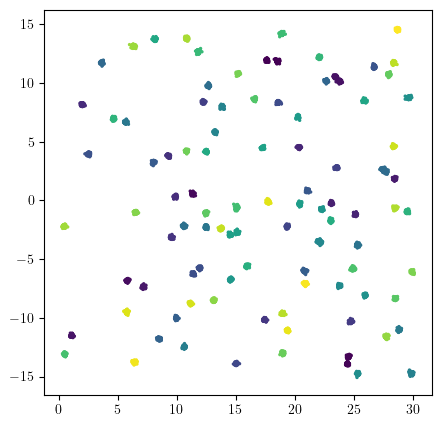

In [26]:
label = []
X = []
for i in range(num_catalog):
    label += [i]*len(cmat[i])
    first_coord, second_coord = cmat[i][:,:2].T
    X += [(i, j) for i, j in zip(first_coord, second_coord)]
label = np.array(label)
X = np.array(X)
sigma_max = 0.1
# sigma_max = 1.0
result = DBSCAN(eps=5*sigma_max, min_samples=2).fit(X)
y_pred = result.labels_
fig = plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y_pred, s=2.0)
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))

In [6]:
def remove_index(candidate_list, df, catalog_list, Sigma_list, index):
    del candidate_list[index]
    df.drop(index = index, inplace=True)
    del catalog_list[index]
    del Sigma_list[index]

{43} 200


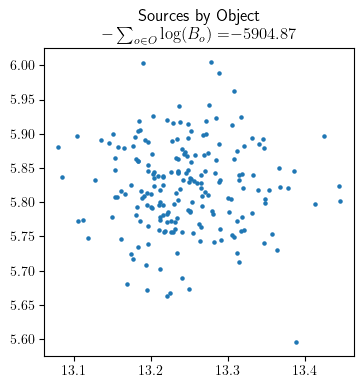

In [36]:
# Get a particular island to run the matching procedure
cluster_num = 42

candidate_list, df, catalog_list, Sigma_list = get_candidate_list(result, label, cluster_num)

# remove_index(candidate_list, df, catalog_list, Sigma_list, 0)

coord_dict = {(row[1],row[0]): (row[2],row[3]) for row in df.itertuples(index=False, name=None)}

detection_total = len(candidate_list) #Total number of sources across different catalogs

kappa_dict = {}
kappa_rad_dict = {}
ln_kappa_rad_dict = {}

for i in range(len(candidate_list)):
    kappa_dict[(candidate_list[i][0], candidate_list[i][1])] = 1/(Sigma_list[i])**2 #in arcsecond 
    kappa_rad_dict[(candidate_list[i][0], candidate_list[i][1])] = 1/((Sigma_list[i]*np.pi/180/3600)**2) #in radian
    ln_kappa_rad_dict[(candidate_list[i][0], candidate_list[i][1])] = ln(1/((Sigma_list[i]*np.pi/180/3600)**2))
    
sigma_min = min(Sigma_list)
sigma_max = max(Sigma_list)

# Used for clustering methods
df2 = df.copy()
kappa_rad_list = []

for row in df2.itertuples():
    cat_id = row.Catalog_id
    source_id = row.Source_id
    kappa_rad = kappa_rad_dict[(source_id,cat_id)]
    kappa_rad_list.append(kappa_rad)

df2["kappa_rad"] = kappa_rad_list

print({t[0] for t in candidate_list}, len(candidate_list))

plot_objects(candidate_list)

### DirILP General Case

# MIP with Quadratic Constraints
Reformulation that uses convex quadratic constraints instead of long linear constraints.

Let $n$ be the number of samples. Let $d_{(i,c)}$ be a samples coordinates. Let $x_{(i,c),j}$ be boolean decision variables of whether sample belongs to a cluster.
$$
\min \left(0.5 * \sum_{(i,c)} r_{(i,c)}\right) + \sum_{j}\left(p_j+\chi_1^jb_{min}+\sum_{(i,c)}\chi_{(i,c)}^j\log(\kappa_{(i,c)})\right)
$$
$$
\kappa_{(i,c)}||d_{(i,c)} - c_j||_2^2 \leq r_{(i,c)} + M(1 - x_{(i,c),j}) \, \text{for all } (i,c),j \\
$$
$$
\forall (i,c), \, \sum_{j} x_{(i,c),j} = 1 \\
$$
$$
\forall j, \forall c, \, \sum_{i} x_{(i,c),j} \leq 1
$$
$$
\forall j, \forall (i,c), p_j \geq \log(2)x_{(i,c)} \\
\forall j, p_j \geq 0
$$
and the log-terms constraints are the same as in the paper.

In [8]:
def get_relaxed_value(model):
    """
    Get the optimal objective function value
    for the relaxed model.
    """
    model.update() # update values
    model.setParam("OutputFlag", 0) # turn off output
    presolved = model.presolve() # presolve
    relaxed = presolved.relax() # relax the model
    relaxed.setParam("OutputFlag", 0) # turn off output for relaxed model
    relaxed.optimize() # optimize relaxed model
    
    return relaxed.objVal

In [46]:
def get_cicle_equidistant_pnts(N):
    theta = np.linspace(0, 2*np.pi, N, endpoint = False)
    xs = np.cos(theta)
    ys = np.sin(theta)
    
    return [(x,y) for x,y in zip(xs,ys)]

time1 = time.perf_counter()

N = 0
dims = 2
num_datapoints = len(coord_dict)
num_clusters = num_datapoints // 2
use_heuristic = False

model = Model("MIP Quad")

# Range of cluster values
x_coords = df['Coordinate_1']
y_coords = df['Coordinate_2']

# Add cluster (c) decision variables
cluster_vars = model.addVars(num_clusters, dims, lb=-float('inf'), ub=float('inf'))

# Add boolean variables
x = model.addVars(candidate_list, list(range(num_clusters)), vtype=GRB.BINARY)

for (source, catalog, k), var in x.items():
    var.setAttr("BranchPriority", 1)

# assigned_set = set()
# for (source, catalog, k), var in x.items():
#     if k not in assigned_set:
#         var.setAttr("BranchPriority", 1)
#         assigned_set.add((source,catalog))

# p variables
p = model.addVars(num_clusters, lb = 0.0, ub = float('inf'))

# Heuristic start
if use_heuristic:
    # Set x binary variables
    for j in range(num_clusters):
        if j not in starting_heuristic_obj_dict:
            continue
        for source, catalog in candidate_list:
            obj_tup_list = starting_heuristic_obj_dict[j]
            if (source,catalog) in obj_tup_list:
                x[source,catalog,j].Start = 1
            else:
                x[source,catalog,j].Start = 0
                
    # Set cluster_vars to be weighted means of points assigned to them
    for j in range(num_clusters):
        if j not in starting_heuristic_obj_dict:
            continue
            
        obj_tup_list = starting_heuristic_obj_dict[j]
        weighted_mean = np.zeros(dims)
        weighted_total = 0
        for source, catalog in candidate_list:
            if (source, catalog) in obj_tup_list:
                weight = kappa_dict[source, catalog]
                weighted_mean += weight * np.array(coord_dict[source, catalog])
                weighted_total += weight
        weighted_mean /= weighted_total
        for d in range(dims):
            cluster_vars[j, d].Start = weighted_mean[d]
    

# Add M variable
M = np.max(pdist(df[["Coordinate_1", "Coordinate_2"]], 'sqeuclidean')) * max(list(kappa_dict.values())) * 1.1 # max pairwise distance * 2
# M = 10**6

# Add r variables
r_dict = model.addVars(candidate_list, lb=0.0, ub=float('inf'))

# Log term
rounding_index = -2 #round number to nearest 10 if rounding_index = -1. to round to nearest 100, change to -2
error_threshold = 1/100 * min(ln_kappa_rad_dict.values())

var_chi_dict = {}
b_list = [ln(1/(sigma_max*np.pi/180/3600)**2)]
# Compute b_list
while b_list[-1] < ln(num_catalog/(sigma_min*np.pi/180/3600)**2):
    b_list.append(b_list[-1]+error_threshold)
    
num_breakpoints = len(b_list) # = P in the paper

# Variables for chi
for j in range(num_clusters):
    for b_i in range(num_breakpoints):
        var_chi_dict[('chi', j, b_i)] = model.addVar(vtype=GRB.BINARY, name=str(('chi', j, b_i)))

### Objective ###
model.setObjective((0.5 * r_dict.sum()) + (np.log(2) * p.sum())
                   + quicksum((b_list[0] * var_chi_dict[('chi', j, 0)])
                              + (error_threshold * quicksum(var_chi_dict[('chi', j, b_i)] for b_i in range(1,num_breakpoints)))
                            for j in range(num_clusters))
                  , GRB.MINIMIZE)

### Constraints ###
# Each point assigned to a cluster
for source, catalog in candidate_list:
    model.addConstr(quicksum(x[(source, catalog, j)] for j in range(num_clusters)) == 1)

# |# objects| * ln(2)
# p = 1 if there is a source in that cluster
# p = 0 if no sources assigned to cluster
for j in range(num_clusters):
    for source, catalog in candidate_list:
        model.addConstr(p[j] >= x[source,catalog,j])
    
# Each cluster has at most one source from a catalog
sources_by_catalog = defaultdict(list)
for source, catalog in coord_dict:
    sources_by_catalog[catalog].append(source)
    
for j,c in itertools.product(range(num_clusters), range(num_catalog)):
    model.addConstr(quicksum(x[(source,c,j)] for source in sources_by_catalog[c]) <= 1)

## Break symmetry ##
# Assignment Symmetry
if not use_heuristic:
    first_s, first_c = candidate_list[0]
    model.addConstr(x[(first_s, first_c, 0)] == 1)
    # Assign other members of the first catalog to other clusters
    clust = 1
    for source, catalog in candidate_list:
        if catalog == first_c and source != first_s:
            model.addConstr(x[(source,catalog,clust)] == 1)
            clust += 1
            
# Cluster Symmetry
# for j in range(num_clusters - 1):
#     model.addConstr(cluster_vars[j,0] <= cluster_vars[j+1,0])

for j in range(num_clusters):
    model.addConstr(cluster_vars[j,0] == [min(x_coords), max(x_coords)])
    model.addConstr(cluster_vars[j,1] == [min(y_coords), max(y_coords)])

circle_pnts = get_cicle_equidistant_pnts(N)

# Big-M constraints
for (source, catalog), coord in coord_dict.items():
    for j in range(num_clusters):
        if N > 0:
            for circle_pnt in circle_pnts:
                # model.addConstr(kappa_dict[source,catalog] * quicksum((cluster_vars[j,k] - coord[k]) * circle_pnt[k] for k in range(dims)) <= r_dict[(source, catalog)] + (M * (1 - x[(source, catalog, j)])))
                model.addGenConstrIndicator(x[source,catalog,j], 1.0, kappa_dict[source,catalog] * quicksum((cluster_vars[j,k] - coord[k]) * circle_pnt[k] for k in range(dims)) <= r_dict[(source, catalog)])
        else:
            model.addQConstr(kappa_dict[(source,catalog)] * (((cluster_vars[j,0] - coord[0]) * (cluster_vars[j,0] - coord[0])) + 
                               ((cluster_vars[j,1] - coord[1]) * (cluster_vars[j,1] - coord[1]))) # in arcseconds ^ 2
                             <= 
                             r_dict[(source, catalog)] + (M * (1 - x[(source, catalog, j)])))

# Definition of variables chi
# Equation B19
for j in range(num_clusters):
    chi_constraint_with_b = []
    chi_constraint = []
    x_constraint = []
    for breakpoint_index in range(1, num_breakpoints):
        chi_constraint_with_b.append(var_chi_dict[('chi', j, breakpoint_index)]*(exp(b_list[breakpoint_index])-exp(b_list[breakpoint_index-1]))/10**10) #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
    for source, catalog in candidate_list:
        x_constraint.append(x[(source, catalog, j)]*kappa_rad_dict[(source, catalog)]/10**10) 
        #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
    model.addConstr(exp(b_list[0])* var_chi_dict[('chi', j, 0)] + quicksum(variable for variable in chi_constraint_with_b) >= quicksum(variable for variable in x_constraint))
    
    for breakpoint_index in range(num_breakpoints):
        chi_constraint.append(var_chi_dict[('chi', j, breakpoint_index)])
    for chi_index in range(len(chi_constraint) - 1):
        model.addConstr(chi_constraint[chi_index] >= chi_constraint[chi_index + 1])
        
# # Heuristic constraints:
# When 2 sources are more than 5*sigma_max away, they should not be from the same object. Hence, set the y variable corresponding to these 2 sources to 0.
# distance_dict = compute_distance_dictionary_2(candidate_list, coord_dict)
# dist_constraint_var=[]
# for pair,distance in distance_dict.items():
#     distance = math.sqrt(distance)
#     (s1,c1), (s2,c2) = pair
#     if distance > 5*sigma_max:
#         model.addConstrs(x[s1,c1,j] + x[s2,c2,j] <= 1 for j in range(num_clusters))
#     elif distance < 0.1*sigma_min:
#         model.addConstrs(x[s1,c1,j] == x[s2,c2,j] for j in range(num_clusters))

# model.setParam('OutputFlag', False)

print("Set Up Time:", time.perf_counter() - time1)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-06
Set Up Time: 1.5570018159996835


In [ ]:
model.setParam('NodefileStart', 5.0)
model.setParam('TuneTimeLimit', 1 * 3600)
model.tune()

Set parameter NodefileStart to value 5
Set parameter TuneTimeLimit to value 3600

Solving model using baseline parameter set with TimeLimit=360s

Testing candidate parameter set 1...

	NodefileStart 5

Solving with random seed #1 ...
Optimize a model with 2461 rows, 1650 columns and 6271 nonzeros
Model fingerprint: 0x66ed5e47
Model has 900 quadratic constraints
Variable types: 180 continuous, 1470 integer (1470 binary)
Coefficient statistics:
  Matrix range     [7e-01, 5e+12]
  QMatrix range    [1e+02, 6e+02]
  QLMatrix range   [1e+00, 2e+04]
  Objective range  [2e-01, 3e+01]
  Bounds range     [3e-01, 1e+00]
  RHS range        [1e+00, 1e+01]
  QRHS range       [3e+04, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1503 rows and 631 columns
Presolve time: 0.03s
Presolved: 958 rows, 1019 columns, 6210 nonzeros
Presolved model has 30 quadratic constraint(s)
Variable types: 120 continuous, 899 integer (89

In [26]:
for i in range(model.tuneResultCount):
    model.getTuneResult(i)
    model.write('qp_tune'+str(i)+'.prm')

In [10]:
model.setParam('NodefileStart', 5)
# model.setParam("MIPFocus", 3)
# model.setParam("SimplexPricing", 2)
# model.setParam("NodefileStart", 5)
# model.setParam("RINS", 0)
# model.setParam("VarBranch", 1)
# model.setParam("CutPasses", 3)
# model.setParam("GomoryPasses", 1)
# model.setParam("PreDual", 1)
# model.setParam("PreQLinearize", 2)
model.setParam("NumericFocus", 2)

model.optimize()

Set parameter NodefileStart to value 5
Set parameter NumericFocus to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1622 rows, 1280 columns and 5062 nonzeros
Model fingerprint: 0x0353d8b0
Model has 800 quadratic constraints
Variable types: 140 continuous, 1140 integer (1140 binary)
Coefficient statistics:
  Matrix range     [7e-01, 5e+12]
  QMatrix range    [1e+02, 6e+02]
  QLMatrix range   [1e+00, 3e+04]
  Objective range  [2e-01, 3e+01]
  Bounds range     [4e-01, 1e+00]
  RHS range        [1e+00, 2e+01]
  QRHS range       [6e+04, 3e+05]
Presolve removed 346 rows and 362 columns
Presolve time: 0.04s
Presolved: 1276 rows, 918 columns, 6604 nonzeros
Presolved model has 20 quadratic constraint(s)
Variable types: 140 continuous, 778 integer (778 binary)

Root relaxation: objective 5.92

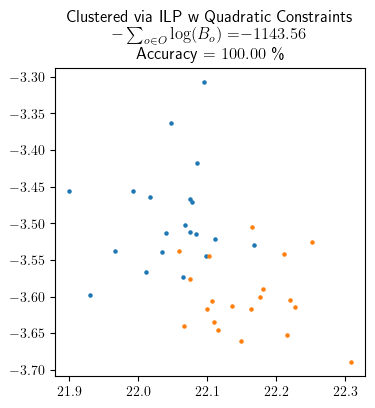

In [11]:
ilpq_obj_dict = defaultdict(list)

for (source, catalog, j), var in x.items():
    if var.X > 0.5:
        ilpq_obj_dict[j].append((source, catalog))

ilpq_y_pred, ilpq_y_true = obj_dict_to_true_pred_labels(ilpq_obj_dict)
ilpq_acc = acc(ilpq_y_pred, ilpq_y_true)
plot_obj_dict(ilpq_obj_dict, "ILP w Quadratic Constraints", neg_log_bayes_from_obj_dict(ilpq_obj_dict, coord_dict), ilpq_acc)

# ILP Formulation

In [54]:
def mycallback(model, where):
    start_time = [0]
    if where == GRB.Callback.POLLING:
        # Ignore polling callback
        pass
    elif where == GRB.Callback.PRESOLVE:
        # Presolve callback
        cdels = model.cbGet(GRB.Callback.PRE_COLDEL) #number of cols removed by presolve to this point
        rdels = model.cbGet(GRB.Callback.PRE_ROWDEL) #number of rows removed by presolve to this point
    elif where == GRB.Callback.SIMPLEX: #Currently in simplex
        # Simplex callback
        itcnt = model.cbGet(GRB.Callback.SPX_ITRCNT) #Current simplex iteration count
        #if itcnt - model._lastiter >= 100:
        model._lastiter = itcnt
        obj = model.cbGet(GRB.Callback.SPX_OBJVAL) # Current simplex objective value
        ispert = model.cbGet(GRB.Callback.SPX_ISPERT) 
        pinf = model.cbGet(GRB.Callback.SPX_PRIMINF) # Current primal infeasibility
        dinf = model.cbGet(GRB.Callback.SPX_DUALINF) # Current dual infeasibility
        if ispert == 0:
            ch = ' '
        elif ispert == 1:
            ch = 'S'
        else:
            ch = 'P'
    elif where == GRB.Callback.MIP: #Currently in MIP
        # General MIP callback
        nodecnt = model.cbGet(GRB.Callback.MIP_NODCNT) #Current explored node count
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST) #Current best objective
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND) #Current best objective bound
        solcnt = model.cbGet(GRB.Callback.MIP_SOLCNT) #Current count of feasible solutions found
        #if nodecnt - model._lastnode >= 100:
        model._lastnode = nodecnt
        actnodes = model.cbGet(GRB.Callback.MIP_NODLFT) #Current unexplored node count
        itcnt = model.cbGet(GRB.Callback.MIP_ITRCNT) #Current simplex iteration count
        cutcnt = model.cbGet(GRB.Callback.MIP_CUTCNT) #Current count of cutting planes applied
    elif where == GRB.Callback.MIPSOL: #Found a new MIP incumbent
        # MIP solution callback
        start_time.append(model.cbGet(GRB.Callback.RUNTIME)) 
        nodecnt = model.cbGet(GRB.Callback.MIPSOL_NODCNT) #Current explored node count
        obj = model.cbGet(GRB.Callback.MIPSOL_OBJ) #Objective value for new solution
        objbst = model.cbGet(GRB.Callback.MIPSOL_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIPSOL_OBJBND)
        solcnt = model.cbGet(GRB.Callback.MIPSOL_SOLCNT) #Curent count of feasible solutions found
        best_gap = abs(100*(objbnd - objbst)/objbst)
        current_gap = abs(100*(objbnd - obj)/obj) #Gap of the new solution found
        x_MIP = model.cbGetSolution(model._vars)
        x_MIP = np.array(x_MIP)
        index_list = np.where(x_MIP > 0.1)
        res_list = [model._vars[i] for i in index_list[0]]
        nonzero_x = []
        for solution in res_list:
            if solution.Varname[1:4] == "'x'":
                nonzero_x.append(solution.VarName)
        # for i in range(len(nonzero_x)):
        #     print('\n x = %s' %nonzero_x[i])
        model._logfile.write('\n**** New solution # %d, Obj %g, Current Gap %g%%, Best Obj %g, Best Gap %g%%, Elapsed time %g,'
               % (solcnt, obj, current_gap, objbst, best_gap, model.cbGet(GRB.Callback.RUNTIME)))
        for i in range(len(nonzero_x)):
            model._logfile.write('\n x = %s' %nonzero_x[i])

    elif where == GRB.Callback.MIPNODE: #Currently exploring a MIP node
        # MIP node callback
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
            x = model.cbGetNodeRel(model._vars) #Values from the node relaxation solution at the current node
            model.cbSetSolution(model.getVars(), x)
    elif where == GRB.Callback.BARRIER:
        # Barrier callback
        itcnt = model.cbGet(GRB.Callback.BARRIER_ITRCNT)
        primobj = model.cbGet(GRB.Callback.BARRIER_PRIMOBJ)
        dualobj = model.cbGet(GRB.Callback.BARRIER_DUALOBJ)
        priminf = model.cbGet(GRB.Callback.BARRIER_PRIMINF)
        dualinf = model.cbGet(GRB.Callback.BARRIER_DUALINF)
        cmpl = model.cbGet(GRB.Callback.BARRIER_COMPL)

    elif where == GRB.Callback.MESSAGE:
        # Message callback
        msg = model.cbGet(GRB.Callback.MSG_STRING)
        model._logfile.write(msg)

In [55]:
######################### ILP Formulation ###########################
import time

use_heuristic = False

t1 = time.perf_counter()

mo = Model("likelihood")

M = np.ceil(1/sigma_min**4*sum_of_distance(candidate_list, df)/(4*1/sigma_max**2))
M_2 = num_catalog * max(kappa_dict.values())
rounding_index = -2 #round number to nearest 10 if rounding_index = -1. to round to nearest 100, change to -2
error_threshold = 1/100 * min(ln_kappa_rad_dict.values())

var_x_dict = {}
# var_y_dict = {}
var_z_dict = {}
var_u_dict = {}
var_chi_dict = {}
t_list = []
p_list = []
b_list = [ln(1/(sigma_max*np.pi/180/3600)**2)]
c_list = [0, round(min(kappa_dict.values()),rounding_index)]
n = len(candidate_list)
########################### SET VARIABLES ###########################

tup_to_ind = {v: i for i, v in enumerate(candidate_list)}

def dist_vec_ind(n,i,j):
    return int((n * (n - 1) / 2)) - int((n - i) * (n - i - 1) / 2) + j - i - 1

def get_y_var(y_vector, i: int, j: int):
    # (i,j) -> (n choose 2) - (n - i choose 2) + (j - i - 1)
    return y_vector[dist_vec_ind(n,i,j)]

# Compute b_list
while b_list[-1] < ln(num_catalog/(sigma_min*np.pi/180/3600)**2): 
    b_list.append(b_list[-1]+error_threshold)

num_breakpoints = len(b_list) # = P in the paper

# Compute c_list
while c_list[-1] < round(num_catalog*max(kappa_dict.values()),rounding_index):
    c_list.append(c_list[-1]+10**(-rounding_index))
    
# Variables for x
for subset_index in range(detection_total):
    for catalog_source_pair in candidate_list:
        
        x = mo.addVar(vtype=GRB.BINARY, name=str(('x', subset_index, catalog_source_pair)))
        # Heuristic start
        if use_heuristic:
            x.Start = 0
            if subset_index in starting_heuristic_obj_dict and catalog_source_pair in starting_heuristic_obj_dict[subset_index]:
                x.Start = 1
            
        var_x_dict[('x', subset_index, catalog_source_pair)] = x
        
var_y_dict = {}
# Variables for y
for subset_index in range(detection_total):
    for product_of_catalog_source_pairs in list(itertools.combinations(candidate_list, r = 2)):
        if product_of_catalog_source_pairs[0][1] != product_of_catalog_source_pairs[1][1]:
            var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])] = mo.addVar(vtype=GRB.BINARY, name=str(('y', subset_index, product_of_catalog_source_pairs[0],product_of_catalog_source_pairs[1])))

# Variables for z
for subset_index in range(detection_total):
    for catalog_index in range(num_catalog + 1):
        var_z_dict[('z', subset_index, catalog_index)] = mo.addVar(vtype=GRB.BINARY, name=str(('z', subset_index, catalog_index)))

# Variables for t
for subset_index in range(detection_total):
    t_list.append(mo.addVar(lb = 0, vtype=GRB.CONTINUOUS, name=str(('t', subset_index))))

# Variables for u
for subset_index in range(detection_total):
    for gridpoint_index in range(len(c_list)):
        var_u_dict[('u', subset_index, gridpoint_index)] = mo.addVar(vtype=GRB.BINARY, name=str(('u', subset_index, gridpoint_index)))
    
# Variables for p
for subset_index in range(detection_total):  
    p_list.append(mo.addVar(lb = -GRB.INFINITY, vtype=GRB.CONTINUOUS, name=str(('p', subset_index))))
    
# Variables for chi
for subset_index in range(detection_total):
    for breakpoint_index in range(num_breakpoints):
        var_chi_dict[('chi', subset_index, breakpoint_index)] = mo.addVar(vtype=GRB.BINARY, name=str(('chi', subset_index, breakpoint_index)))

########################### SET OBJECTIVES ###########################

# Set objective
mo.setObjective(quicksum(p_list[subset_index]
                         - quicksum(var_x_dict['x',subset_index,catalog_source_pair]*ln_kappa_rad_dict[catalog_source_pair] for catalog_source_pair in candidate_list) 
                         + b_list[0]*var_chi_dict[('chi', subset_index, 0)] + error_threshold*quicksum(var_chi_dict[('chi', subset_index, breakpoint_index)] for breakpoint_index in range(1,num_breakpoints))
                         + t_list[subset_index] for subset_index in range(detection_total)), GRB.MINIMIZE)

########################### SET CONSTRAINTS ###########################

# All detections (i,c) needs to belong to some subset (S_j)
# Equation B14
for catalog_source_pair in candidate_list:
    x_constraint = []
    for variable in var_x_dict.keys():
        if variable[-1] == catalog_source_pair:
            x_constraint.append(var_x_dict[variable])
    mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.EQUAL, rhs = 1)

# Every subset takes no more than 1 detection from each catalog
# Equation B15
for subset_index in range(detection_total):
    for catalog_index in catalog_list:
        x_constraint = []
        for variable in var_x_dict.keys():
            if (variable[1] == subset_index) & (variable[-1][1] == catalog_index):
                x_constraint.append(var_x_dict[variable])
        mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.LESS_EQUAL, rhs = 1)

# Definition of variables y
# Equation B16
for subset_index in range(detection_total):
    for product_of_catalog_source_pairs in list(itertools.combinations(candidate_list, r = 2)): 
        if product_of_catalog_source_pairs[0][1] != product_of_catalog_source_pairs[1][1]:
            mo.addConstr(var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])] >= var_x_dict[('x', subset_index, product_of_catalog_source_pairs[0])] 
                         + var_x_dict[('x', subset_index, product_of_catalog_source_pairs[1])] - 1)
            mo.addConstr(var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])] <= var_x_dict[('x', subset_index, product_of_catalog_source_pairs[0])])
            mo.addConstr(var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])] <= var_x_dict[('x', subset_index, product_of_catalog_source_pairs[1])])
            

# The cardinality of any subset from a partition P is from 0 to K
# Equation B17
for subset_index in range(detection_total):
    z_constraint = []
    for catalog_index in range(num_catalog + 1):
        z_constraint.append(var_z_dict[('z', subset_index, catalog_index)])
    mo.addConstr(lhs = quicksum(variable for variable in z_constraint), sense=GRB.EQUAL, rhs = 1)
    
# Only 1 of u^o_k is 1
# Equation B18
for subset_index in range(detection_total):
    u_constraint = []
    for gridpoint_index in range(len(c_list)):
        u_constraint.append(var_u_dict[('u', subset_index, gridpoint_index)])
    mo.addConstr(lhs = quicksum(variable for variable in u_constraint), sense=GRB.EQUAL, rhs = 1)
    
# Definition of variables chi
# Equation B19
for subset_index in range(detection_total):
    chi_constraint_with_b = []
    chi_constraint = []
    x_constraint = []
    for breakpoint_index in range(1, num_breakpoints):
        chi_constraint_with_b.append(var_chi_dict[('chi', subset_index, breakpoint_index)]*(exp(b_list[breakpoint_index])-exp(b_list[breakpoint_index-1]))/10**10) #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
    for catalog_source_pair in candidate_list:    
        x_constraint.append(var_x_dict[('x', subset_index, catalog_source_pair)]*kappa_rad_dict[catalog_source_pair]/10**10) 
        #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
    mo.addConstr(lhs = exp(b_list[0])* var_chi_dict[('chi', subset_index, 0)] + quicksum(variable for variable in chi_constraint_with_b), 
                 sense=GRB.GREATER_EQUAL, 
                 rhs = quicksum(variable for variable in x_constraint))
    
    for breakpoint_index in range(num_breakpoints):
        chi_constraint.append(var_chi_dict[('chi', subset_index, breakpoint_index)])
    for chi_index in range(len(chi_constraint) - 1):
        mo.addConstr(chi_constraint[chi_index] >= chi_constraint[chi_index + 1])
        
# Definition of variables t
# Equation B20
product_of_cat_source_pairs_list = [prod for prod in list(itertools.combinations(candidate_list, r = 2)) if prod[0][1] != prod[1][1]]
    
weighted_dist_dict = {}    

for p_tups in product_of_cat_source_pairs_list:
    weighted_dist_dict[p_tups] = kappa_dict[p_tups[0]]*kappa_dict[p_tups[1]] * get_distance_2(p_tups, coord_dict)

for subset_index in range(detection_total):
    for gridpoint_index in range(1,len(c_list)):
        # mo.addConstr(lhs = t_list[subset_index], sense=GRB.GREATER_EQUAL,
        #              rhs = -M * (1 - var_u_dict[('u', subset_index, gridpoint_index)])
        #              + (1/(2*c_list[gridpoint_index])
        #                  * quicksum(var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])]
        #                         *kappa_dict[product_of_catalog_source_pairs[0]]*kappa_dict[product_of_catalog_source_pairs[1]]
        #                         *get_distance_2(product_of_catalog_source_pairs, coord_dict) for product_of_catalog_source_pairs in product_of_cat_source_pairs_list)
        #             ))
        mo.addConstr(lhs = t_list[subset_index], sense=GRB.GREATER_EQUAL,
                     rhs = -M * (1 - var_u_dict[('u', subset_index, gridpoint_index)])
                     + (1/(2*c_list[gridpoint_index])
                         * quicksum(var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])]
                                    * weighted_dist_dict[product_of_catalog_source_pairs]
                                    for product_of_catalog_source_pairs in product_of_cat_source_pairs_list)
                    ))

# Definition of variables z
# Equation B21
for subset_index in range(detection_total):
    x_constraint = []
    for catalog_source_pair in candidate_list:
        x_constraint.append(var_x_dict[('x', subset_index, catalog_source_pair)])
    for catalog_index in range(num_catalog + 1):
        mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.LESS_EQUAL,
                     rhs = catalog_index * var_z_dict[('z', subset_index, catalog_index)] + num_catalog * (1 - var_z_dict[('z', subset_index, catalog_index)]))
        mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.GREATER_EQUAL,
                     rhs = catalog_index * var_z_dict[('z', subset_index, catalog_index)])

# Definition of variables u
# Equation B222
for subset_index in range(detection_total):
    x_constraint = []
    for catalog_source_pair in candidate_list:
        x_constraint.append(var_x_dict[('x', subset_index, catalog_source_pair)]*round(kappa_dict[catalog_source_pair],rounding_index))
    for gridpoint_index in range(len(c_list)):
        mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.LESS_EQUAL,
                     rhs = c_list[gridpoint_index] * var_u_dict[('u', subset_index, gridpoint_index)] + M_2 * (1 - var_u_dict[('u', subset_index, gridpoint_index)]))
        mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.GREATER_EQUAL,
                     rhs = c_list[gridpoint_index] * var_u_dict[('u', subset_index, gridpoint_index)])
    
# Definition of variables p
# Equation B23
for subset_index in range(detection_total):
    x_constraint = []
    for catalog_source_pair in candidate_list:    
        x_constraint.append(var_x_dict[('x', subset_index, catalog_source_pair)])
    mo.addConstr(lhs = p_list[subset_index], sense=GRB.GREATER_EQUAL, 
                     rhs = ln(2)*(1 - quicksum(variable for variable in x_constraint) - ln(2)*var_z_dict[('z', subset_index, 0)]))

# Heuristic constraints:
# When 2 sources are more than 5*sigma_max away, they should not be from the same object. Hence, set the y variable corresponding to these 2 sources to 0.
distance_dict = compute_distance_dictionary_2(candidate_list, coord_dict)
dist_constraint_var=[]
for pair,distance in distance_dict.items():
    for j in range(detection_total):
        if distance > 5*sigma_max:
            dist_constraint_var.append(var_y_dict[tuple(['y']+[j]+list(pair))])
for variable in dist_constraint_var:
    variable.ub = 0
    
    
# Break symmetry
mo.addConstr(var_x_dict[('x', 0, candidate_list[0])] == 1.0)

print(f"Set Up Time: {(time.perf_counter() - t1)}")

Set Up Time: 7.610321772001043


In [10]:
mo.setParam('TuneTimeLimit', 12 * 3600)
mo.tune()

Set parameter TuneTimeLimit to value 43200

Solving model using baseline parameter set with TimeLimit=4320s

Testing candidate parameter set 1...

	Default parameters

Solving with random seed #1 ...
Optimize a model with 209701 rows, 72650 columns and 10753101 nonzeros
Model fingerprint: 0xd7f7620f
Variable types: 100 continuous, 72550 integer (72550 binary)
Coefficient statistics:
  Matrix range     [1e-05, 5e+12]
  Objective range  [3e-01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 3e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 9456 rows and 2753 columns (presolve time = 5s) ...
Presolve removed 12156 rows and 5403 columns (presolve time = 10s) ...
Presolve removed 17506 rows and 5453 columns (presolve time = 15s) ...
Presolve removed 17556 rows and 5503 columns (presolve time = 20s) ...
Presolve removed 17606 rows and 5553 columns (presolve time = 25s) ...
Presolve removed 

In [56]:
# Open log file
# mo.update()

# logfile = open('DirILP_'+str(num_catalog)+'_catalogs.log', 'w')
# logfile.write('Theoretical optimal solution: %s' % (Bayes_factor(candidate_list,coord_dict)))

# Pass data into my callback function
# mo._logfile = logfile
# mo._vars = mo.getVars()

# Solve model
# mo.Params.MIPGap = 0.02
# mo.optimize(mycallback)
mo.optimize()

# Close log file

# logfile.close()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110401 rows, 38640 columns and 4520721 nonzeros
Model fingerprint: 0xd0352495
Variable types: 80 continuous, 38560 integer (38560 binary)
Coefficient statistics:
  Matrix range     [1e-05, 5e+12]
  Objective range  [3e-01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.600000e+11
Presolve removed 11246 rows and 3483 columns (presolve time = 5s) ...
Presolve removed 11366 rows and 3603 columns (presolve time = 10s) ...
Presolve removed 11126 rows and 3363 columns
Presolve time: 10.54s
Presolved: 99275 rows, 35277 columns, 2550960 nonzeros
Found heuristic solution: objective 

In [38]:
from collections import defaultdict
import math

def g_var_to_tuple(g_var) -> tuple[int,int,int]:
    strs = g_var.varName.split()
    obj_num = int(strs[1].strip(','))
    source_num = int(strs[2].strip('(').strip(','))
    cat_num = int(strs[3].strip(')'))
    return obj_num, source_num, cat_num

def get_obj_dict_dir_ilp(g_vars: list, coord_dict: dict[tuple[int,int],tuple[float,float]]):
    obj_tuples = [g_var_to_tuple(v) for v in g_vars]
    # Group by object index
    grouped_by_object = defaultdict(list)
    
    for obj_num, source_num, cat_num in obj_tuples:
        grouped_by_object[obj_num].append((source_num, cat_num))
    return grouped_by_object

g_vars = []

for i in mo.getVars():
    if i.x > 0.5:
        if i.VarName[1:4] == "'x'":
            g_vars.append(i)

dir_obj_dict = get_obj_dict_dir_ilp(g_vars, coord_dict)
ilp_y_pred, ilp_y_true = obj_dict_to_true_pred_labels(dir_obj_dict)
print(f"Accuracy: {acc(ilp_y_pred, ilp_y_true) * 100:.2f}%")

Accuracy: 100.00%


# Bayes Factor

## DIR ILP

In [15]:
dir_obj_dict = get_obj_dict_dir_ilp(g_vars, coord_dict)
neg_log_bayes_from_obj_dict(dir_obj_dict, coord_dict)

-536.5086252390811

## Weighted K Means

In [19]:
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict

In [28]:
X = np.zeros((len(coord_dict), 2))
sample_weights = np.zeros(len(coord_dict))

tup_dict = dict()

for i, (t, coord) in enumerate(coord_dict.items()):
    X[i,:] = coord
    sample_weights[i] = kappa_dict[t]
    tup_dict[i] = t
    
bayes_list = []
k_list = []
best_kmeans_obj = dict()
best_b = np.inf
best_k = 0
# for k in tqdm(range(1,df.shape[0]+1)):

# Minimum number of clusters is max number of objects in any catalog
_, counts = np.unique(catalog_list, return_counts=True)

min_k = np.max(counts)

# for k in tqdm(range(min_k,10)):
for k in tqdm(range(1,10)):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X = X, sample_weight=sample_weights)

    kmeans.labels_

    obj_dict = defaultdict(list)

    for i, obj_num in enumerate(kmeans.labels_):
        obj_dict[obj_num].append(tup_dict[i])

    kmeans_obj_dict = obj_dict
    b = neg_log_bayes_from_obj_dict(kmeans_obj_dict, coord_dict)
    if b < best_b:
        best_b = b
        best_kmeans_obj = kmeans_obj_dict
        best_k = k
    bayes_list.append(b)
    k_list.append(k)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 29.22it/s]


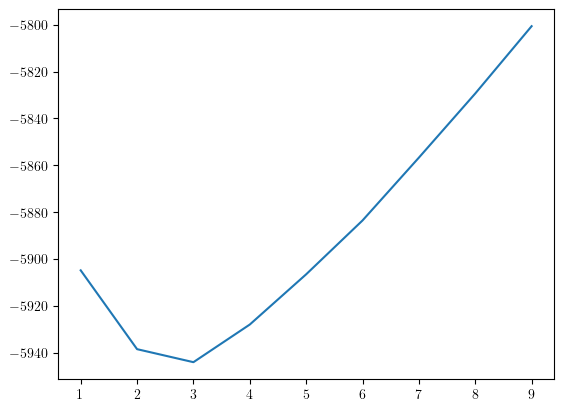

In [29]:
plt.plot(k_list,bayes_list)

# Single-Linkage Heuristic

In [172]:
from single_linkage_heuristic import *

def find_clusters_single_linkage(
    cmat: np.array, cat_tuples, coord_dict
) -> tuple[np.array, int, float, list[float]]:
    """Find clusters using single linkage clustering."""
    
    data = np.concatenate(cmat, axis=0)
    linkage_arr = linkage(data[:, :2], method="single")
    num_cats = len(np.unique([t[1] for t in cat_tuples]))
    bayes = []
    best_bayes = np.inf
    best_obj_dict: np.array = None
    best_n: int = 0
    for n in range(num_cats, data.shape[0]):
        cluster_labels = fcluster(linkage_arr, t=n, criterion="maxclust")
        obj_dict = defaultdict(list)
        for l, t in zip(cluster_labels, cat_tuples):
            obj_dict[l].append(t)
        bayes_factor = neg_log_bayes_from_obj_dict(obj_dict, coord_dict)
        # bayes_factor = -1 * assign_cluster_neg_bayes(cluster_labels, data)
        bayes.append(bayes_factor)
        if bayes_factor < best_bayes:
            best_bayes = bayes_factor
            best_obj_dict = obj_dict
            best_n = n

    return best_obj_dict, best_n, best_bayes, bayes

In [173]:
cmat_sub = df2[['Coordinate_1', 'Coordinate_2', 'kappa_rad']].to_numpy()
cmat_sub = np.expand_dims(cmat_sub, 0)
single_linkage_obj_dict, best_n, best_bayes, bayes = find_clusters_single_linkage(cmat_sub, candidate_list, coord_dict)

# COP-KMeans

In [42]:
from cop_kmeans import cop_kmeans
from tqdm import tqdm

# Create cannot-links (list of tuples)
catalog_groups = defaultdict(list)
for t in candidate_list:
    catalog_groups[t[1]].append(t)
    
X = np.zeros((len(coord_dict), 2))
sample_weights = np.zeros(len(coord_dict))

tup_dict = dict()

cannot_link_dict: dict[int,list[int]] = defaultdict(list)
for i, (t, coord) in enumerate(coord_dict.items()):
    cannot_link_dict[t[1]].append(i)
    X[i,:] = coord
    sample_weights[i] = kappa_dict[t]
    tup_dict[i] = t

import itertools

cannot_link = []

for l in cannot_link_dict.values():
    for comb in itertools.combinations(l,2):
        cannot_link.append(comb)

bayes_list = []
k_list = []
best_cop_obj_dict = dict()
best_b = np.inf
# for k in [2]:
# for k in tqdm(range(1,df.shape[0]+1)):
for k in tqdm(range(1,10)):
# for k in tqdm(range(best_k,best_k+1)):
    clusters, centers = cop_kmeans(dataset=X, initialization="kmpp", k=k, ml=[],cl=cannot_link, sample_weights=sample_weights)
    
    if clusters is None:
        continue

    obj_dict = defaultdict(list)
    for c,t in zip(clusters, candidate_list):
        obj_dict[c].append(t)

    b = neg_log_bayes_from_obj_dict(obj_dict, coord_dict)
    if b < best_b:
        best_b = b
        best_cop_obj_dict = obj_dict
    bayes_list.append(b)
    k_list.append(k)

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8/9 [00:00<00:00, 37.83it/s]

defaultdict(<class 'list'>, {0: [(43, 0), (43, 1), (43, 2), (43, 3), (43, 4), (43, 5), (43, 6), (43, 7), (43, 8), (43, 9), (43, 10), (43, 11), (43, 12), (43, 13), (43, 14), (43, 15), (43, 16), (43, 17), (43, 18), (43, 19), (43, 20), (43, 21), (43, 22), (43, 23), (43, 24), (43, 25), (43, 26), (43, 27), (43, 28), (43, 29), (43, 30), (43, 31), (43, 32), (43, 33), (43, 34), (43, 35), (43, 36), (43, 37), (43, 38), (43, 39), (43, 40), (43, 41), (43, 42), (43, 43), (43, 44), (43, 45), (43, 46), (43, 47), (43, 48), (43, 49), (43, 50), (43, 51), (43, 52), (43, 53), (43, 54), (43, 55), (43, 56), (43, 57), (43, 58), (43, 59), (43, 60), (43, 61), (43, 62), (43, 63), (43, 64), (43, 65), (43, 66), (43, 67), (43, 68), (43, 69), (43, 70), (43, 71), (43, 72), (43, 73), (43, 74), (43, 75), (43, 76), (43, 77), (43, 78), (43, 79), (43, 80), (43, 81), (43, 82), (43, 83), (43, 84), (43, 85), (43, 86), (43, 87), (43, 88), (43, 89), (43, 90), (43, 91), (43, 92), (43, 93), (43, 94), (43, 95), (43, 96), (43, 97

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 36.41it/s]

defaultdict(<class 'list'>, {4: [(43, 0), (43, 4), (43, 20), (43, 29), (43, 35), (43, 37), (43, 44), (43, 63), (43, 69), (43, 96), (43, 103), (43, 114), (43, 119), (43, 123), (43, 140), (43, 142), (43, 161), (43, 162), (43, 165), (43, 168), (43, 191)], 3: [(43, 1), (43, 10), (43, 14), (43, 16), (43, 30), (43, 32), (43, 38), (43, 47), (43, 60), (43, 73), (43, 75), (43, 83), (43, 87), (43, 88), (43, 90), (43, 129), (43, 143), (43, 146), (43, 163), (43, 172), (43, 179), (43, 180), (43, 181), (43, 183), (43, 192), (43, 197)], 0: [(43, 2), (43, 9), (43, 13), (43, 15), (43, 18), (43, 31), (43, 53), (43, 56), (43, 57), (43, 70), (43, 72), (43, 100), (43, 102), (43, 104), (43, 110), (43, 135), (43, 136), (43, 138), (43, 159), (43, 166), (43, 194)], 6: [(43, 3), (43, 8), (43, 26), (43, 28), (43, 33), (43, 46), (43, 50), (43, 61), (43, 68), (43, 74), (43, 79), (43, 86), (43, 105), (43, 107), (43, 108), (43, 113), (43, 116), (43, 121), (43, 125), (43, 147), (43, 154), (43, 155), (43, 160), (43, 1

# Plot Methods

In [43]:
# single_linkage_y_pred, single_linkage_y_true = obj_dict_to_true_pred_labels(single_linkage_obj_dict)
kmeans_y_pred, kmeans_y_true = obj_dict_to_true_pred_labels(best_kmeans_obj)
# cop_y_pred, cop_y_true = obj_dict_to_true_pred_labels(best_cop_obj_dict)

# single_linkage_acc = acc(single_linkage_y_pred, single_linkage_y_true)
kmeans_acc = acc(kmeans_y_pred, kmeans_y_true)
# cop_kmeans_acc = acc(cop_y_pred, cop_y_true)

defaultdict(<class 'list'>, {43: [(43, 0), (43, 1), (43, 2), (43, 3), (43, 4), (43, 5), (43, 6), (43, 7), (43, 8), (43, 9), (43, 10), (43, 11), (43, 12), (43, 13), (43, 14), (43, 15), (43, 16), (43, 17), (43, 18), (43, 19), (43, 20), (43, 21), (43, 22), (43, 23), (43, 24), (43, 25), (43, 26), (43, 27), (43, 28), (43, 29), (43, 30), (43, 31), (43, 32), (43, 33), (43, 34), (43, 35), (43, 36), (43, 37), (43, 38), (43, 39), (43, 40), (43, 41), (43, 42), (43, 43), (43, 44), (43, 45), (43, 46), (43, 47), (43, 48), (43, 49), (43, 50), (43, 51), (43, 52), (43, 53), (43, 54), (43, 55), (43, 56), (43, 57), (43, 58), (43, 59), (43, 60), (43, 61), (43, 62), (43, 63), (43, 64), (43, 65), (43, 66), (43, 67), (43, 68), (43, 69), (43, 70), (43, 71), (43, 72), (43, 73), (43, 74), (43, 75), (43, 76), (43, 77), (43, 78), (43, 79), (43, 80), (43, 81), (43, 82), (43, 83), (43, 84), (43, 85), (43, 86), (43, 87), (43, 88), (43, 89), (43, 90), (43, 91), (43, 92), (43, 93), (43, 94), (43, 95), (43, 96), (43, 9

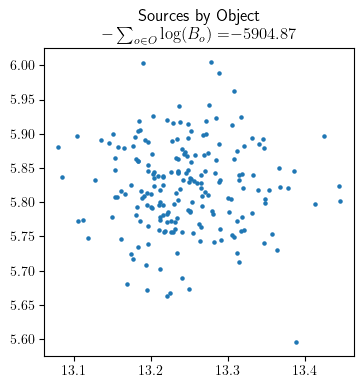

defaultdict(<class 'list'>, {0: [(43, 0), (43, 1), (43, 3), (43, 4), (43, 10), (43, 14), (43, 16), (43, 20), (43, 29), (43, 30), (43, 32), (43, 35), (43, 37), (43, 38), (43, 43), (43, 44), (43, 47), (43, 49), (43, 50), (43, 51), (43, 58), (43, 60), (43, 63), (43, 65), (43, 68), (43, 69), (43, 73), (43, 80), (43, 83), (43, 87), (43, 88), (43, 90), (43, 94), (43, 96), (43, 103), (43, 107), (43, 108), (43, 113), (43, 114), (43, 116), (43, 119), (43, 123), (43, 125), (43, 127), (43, 129), (43, 140), (43, 141), (43, 142), (43, 143), (43, 146), (43, 147), (43, 156), (43, 160), (43, 161), (43, 162), (43, 163), (43, 165), (43, 167), (43, 168), (43, 172), (43, 174), (43, 179), (43, 180), (43, 181), (43, 183), (43, 184), (43, 191), (43, 192), (43, 195), (43, 197), (43, 198)], 2: [(43, 2), (43, 5), (43, 6), (43, 7), (43, 9), (43, 12), (43, 13), (43, 15), (43, 17), (43, 18), (43, 23), (43, 24), (43, 27), (43, 31), (43, 34), (43, 36), (43, 45), (43, 53), (43, 54), (43, 64), (43, 66), (43, 70), (43,

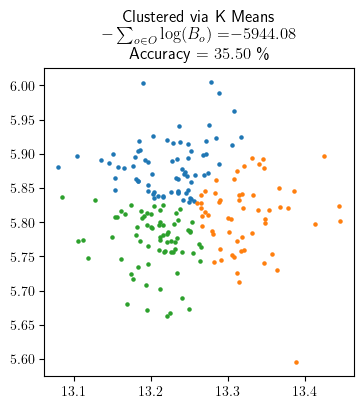

In [44]:
# plot_catalogs(candidate_list, f"figures/catalogs_{num_catalog}_{cluster_num}.svg")
plot_objects(candidate_list, f"figures/objects_{num_catalog}_{cluster_num}.svg")
# plot_obj_dict(single_linkage_obj_dict, "Single Linkage", neg_log_bayes_from_obj_dict(single_linkage_obj_dict, coord_dict), single_linkage_acc, f"figures/single_linkage_{num_catalog}_{cluster_num}.svg")
plot_obj_dict(best_kmeans_obj, "K Means", neg_log_bayes_from_obj_dict(best_kmeans_obj, coord_dict), kmeans_acc, f"figures/kmeans_{num_catalog}_{cluster_num}.svg")
# plot_obj_dict(dir_obj_dict, "DIR ILP", neg_log_bayes_from_obj_dict(dir_obj_dict, coord_dict), ilp_acc, f"figures/ilp_{num_catalog}_{cluster_num}.svg")
# plot_obj_dict(best_cop_obj_dict, "COP K-Means", neg_log_bayes_from_obj_dict(best_cop_obj_dict, coord_dict), cop_kmeans_acc, f"figures/cop_{num_catalog}_{cluster_num}.svg")